# Embedding Visualisation

In [1]:
%reload_ext autoreload
%autoreload 2

import utilities as my_utils
from testing_embeddings import *
import ast
import logging
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from sklearn.manifold import TSNE

import utilities as my_utils
from multihotembedding import MultihotEmbedding
from qualities import QUALITY_DICT, KEYS, CLASSIFICATION

import pandas as pd
from pychord import Chord

In [2]:
sentences = my_utils.build_sentences()
VAL_FILE = "data/validation/test_chords_double_pairs.txt"

In [3]:
ft = FastText.load("embeddings/fastText.model")
w2vCBOW = Word2Vec.load("embeddings/word2vecCBOW.model")
w2vSG = Word2Vec.load("embeddings/word2vecSG.model")
mh = MultihotEmbedding.load("embeddings/multihotembedding.model")

In [4]:
w2vCBOW70 = Word2Vec(sentences=sentences, min_count=0, size=70, window=4, sg=0)
w2vSG70 = Word2Vec(sentences=sentences, min_count=0, size=70, window=4, sg=1)
ft70 = FastText(sentences=sentences, min_count=0, size=70, window=4)

In [5]:
models_list = [w2vCBOW, w2vSG, ft, mh, w2vCBOW70, w2vSG70, ft70]

In [6]:
for m in models_list:
    print_accuracy(m, VAL_FILE)

Word2Vec CBOW Size: 13 0.2766
Word2Vec Skip-Gram Size: 14 0.2727
FastText Size: 13 0.2868
MultihotEmbedding Size: 33 0.0
Word2Vec CBOW Size: 70 0.201
Word2Vec Skip-Gram Size: 70 0.1895
FastText Size: 70 0.2279


In [18]:
get_model_name(w2vCBOW)

'Word2Vec CBOW Size: 13 Window: 2'

In [30]:
def plot_reduction(x, y, labels, selected_indices, suptitle, title, layout):
    plt.figure(figsize=(10, 7))
    size = 12
    weight = 'normal'
    if layout == 'big':
        size = 16
        weight = 'bold'
    plt.scatter(x, y, alpha=0.7, marker=".")
    plt.xticks([])
    plt.yticks([])
    plt.suptitle(suptitle, fontweight="bold", size=20)
    plt.title(title, size=13)
    
    texts = []
    for i in selected_indices:
        texts.append(plt.annotate(labels[i], (x[i], y[i]), size=size, weight=weight))
        plt.scatter(x[i], y[i], c='orange', marker="o", edgecolors='k', s=40)
        plt.plot(x[i], y[i])
    adjust_text(texts, x[selected_indices], y[selected_indices], arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
#     adjust_text([plt.text(max(x), min(y), "Mateusz Dorobek 2020", alpha=0.5, color='gray', fontname="Helvetica", size='x-large')])
    filename = (suptitle + title).replace(":","").replace(" ","").replace("-","")
    plt.savefig("images/embeddings/" + filename+".pdf")
    plt.show()


In [31]:
def get_model_name(model, stripped=False):
    model_name = str(model).split("(")[0]
    if model_name == "Word2Vec":
        if model.sg:
            model_name += " Skip-Gram"
        else:
            model_name += " CBOW"

    embedding_size = str(model).split("=")[2].split(",")[0]
    model_name += " Size: " + embedding_size
    
    try:
        window = str(model.window)
    except:
        window = ""
    model_name += " Window: " + window
    
    model_name = model_name.replace(")", "")
    if stripped:
        model_name = model_name.replace(":", "").replace(" ", "").replace("-", "")
    return model_name

In [32]:
def plot_test_cases(model):
    df = pd.read_csv("data/validation/test_chords_groups_for_embedding.txt", header=None, sep=";")
    chords_groups = [ast.literal_eval(chords_string) for chords_string in df.values[:, 1]]
    titles = list(df.values[:, 0])
    x, y, labels = tSNE_reduction(model)
    model_name = get_model_name(model)
    for title, chords in zip(titles, chords_groups):
        indices = []
        for chord in chords:
            indices.append(np.where(labels == chord)[0][0])
        if "Circle of Fifths" in title:
            layout='normal'
        else:
            layout='big'
        plot_reduction(x, y, labels, indices, title, model_name, layout=layout)

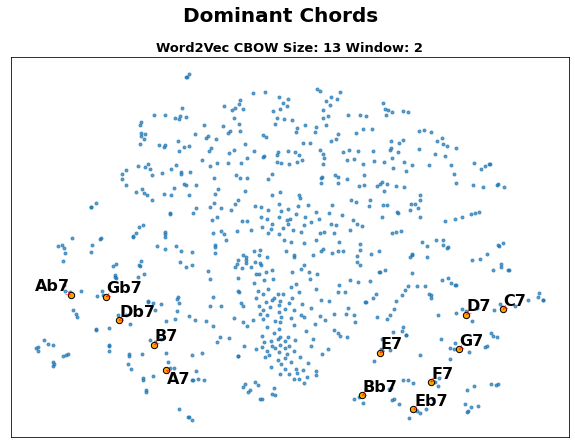

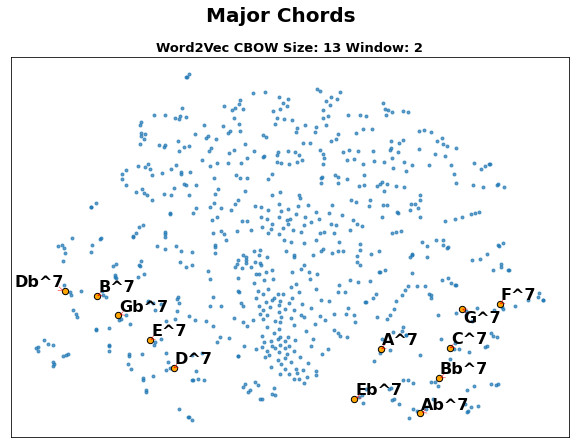

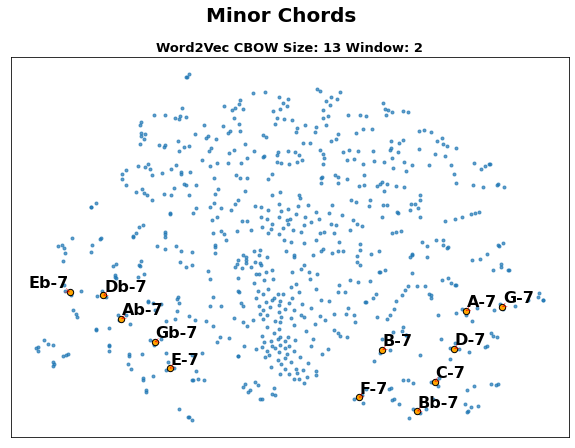

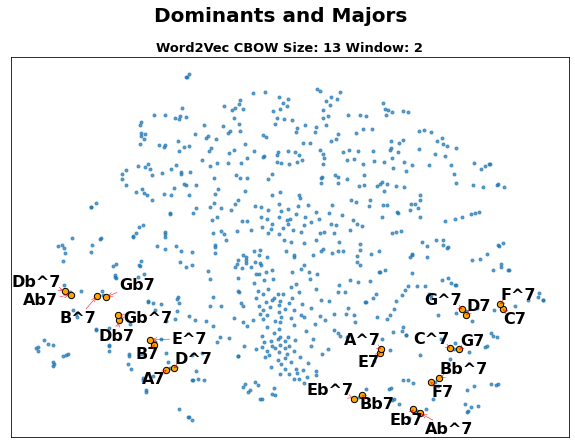

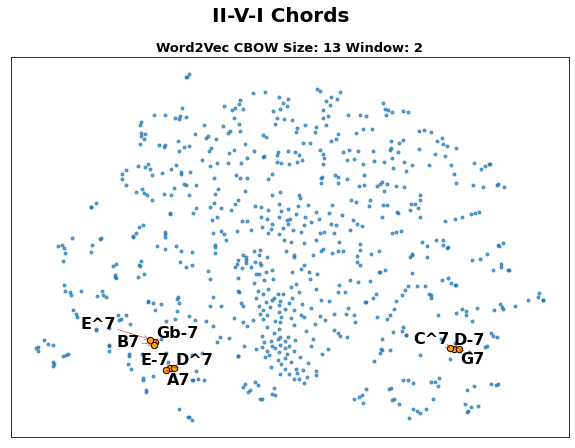

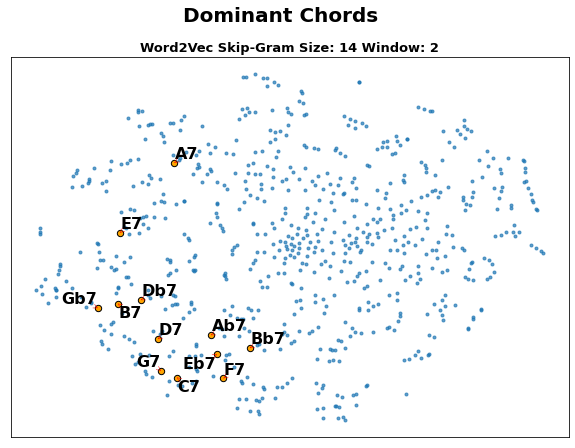

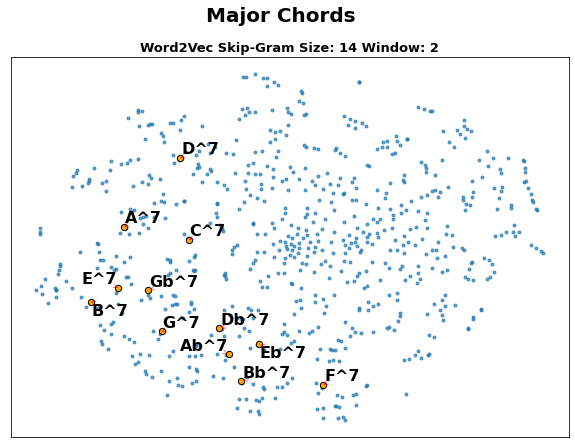

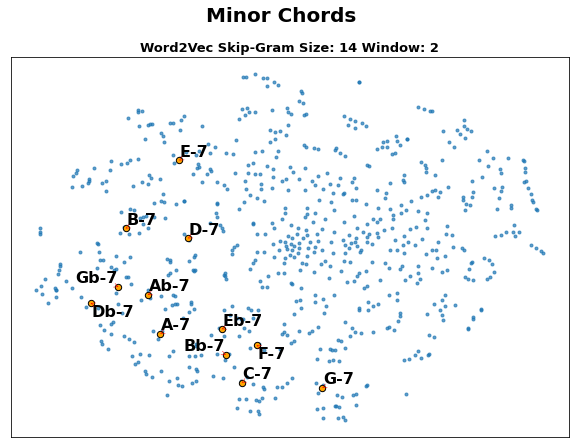

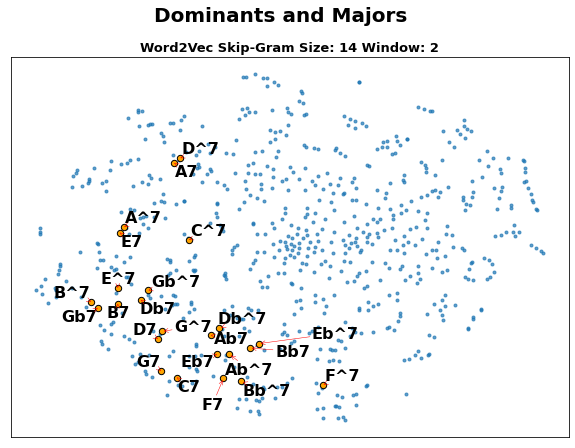

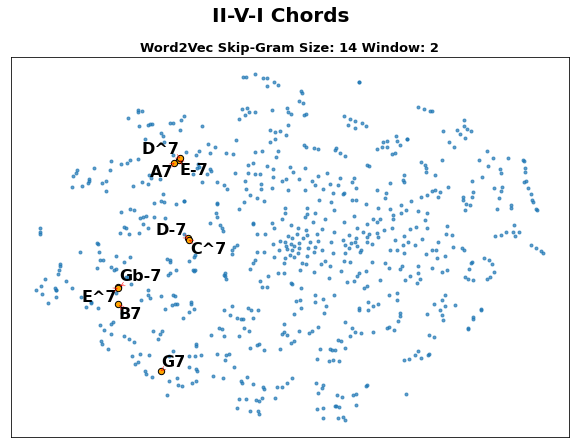

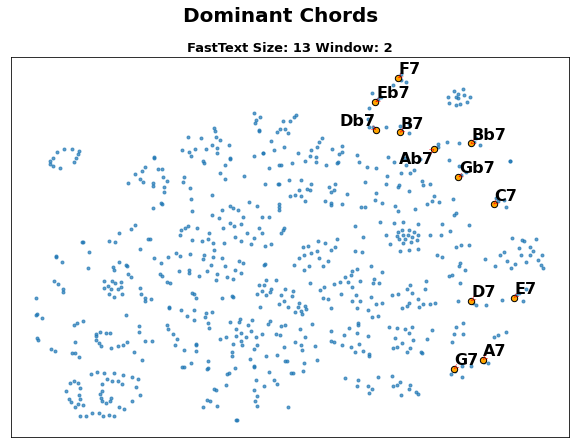

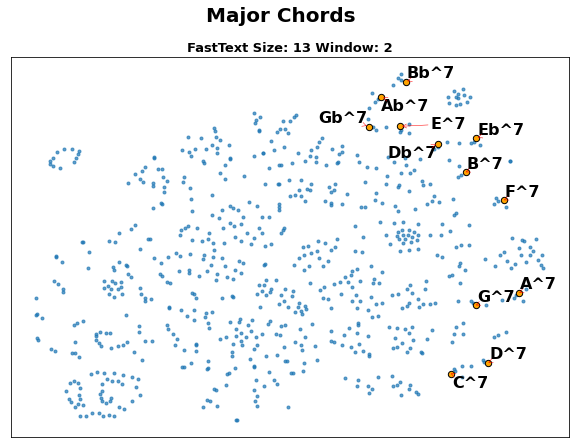

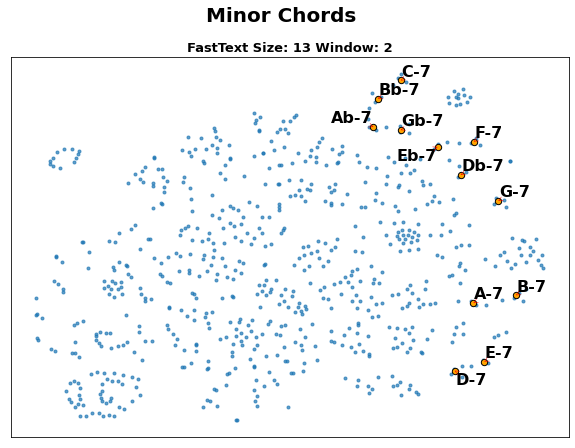

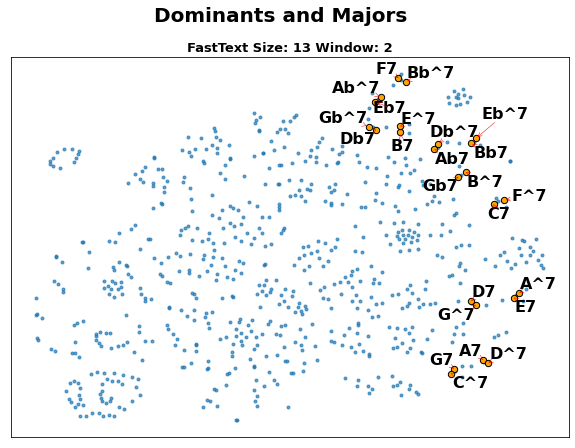

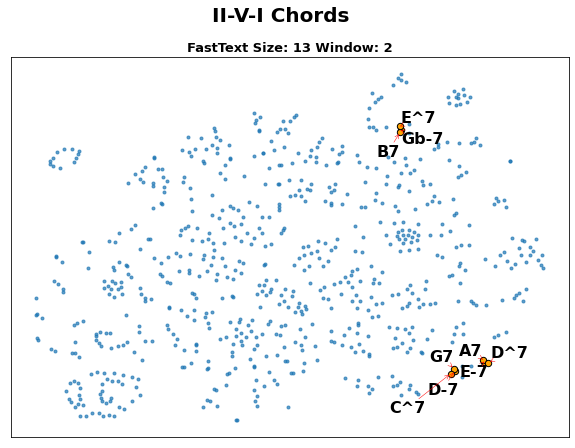

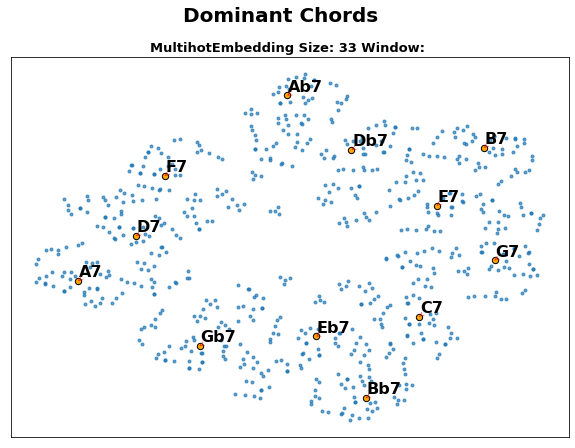

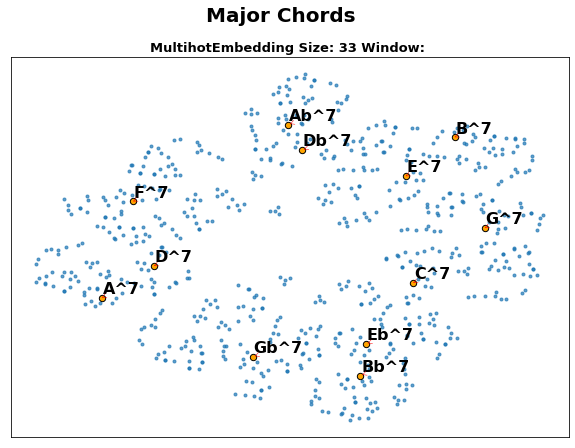

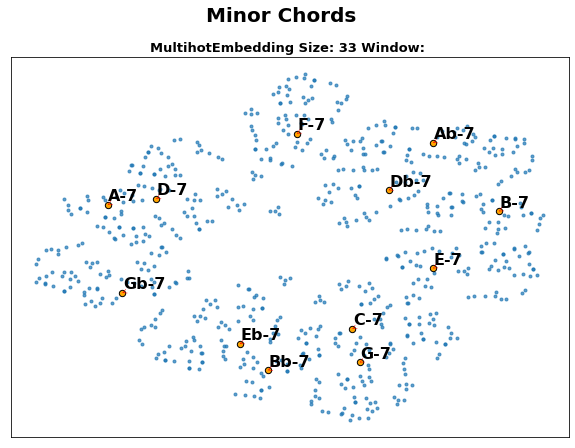

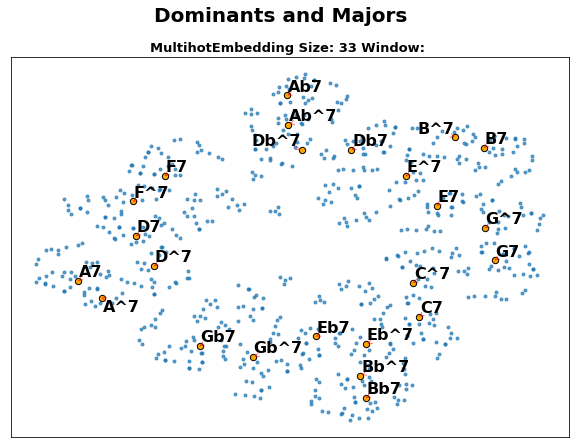

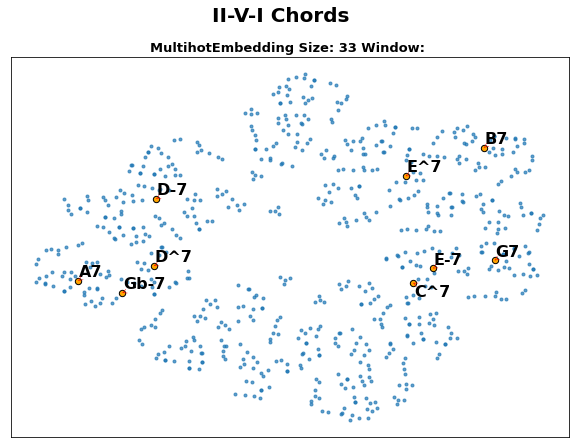

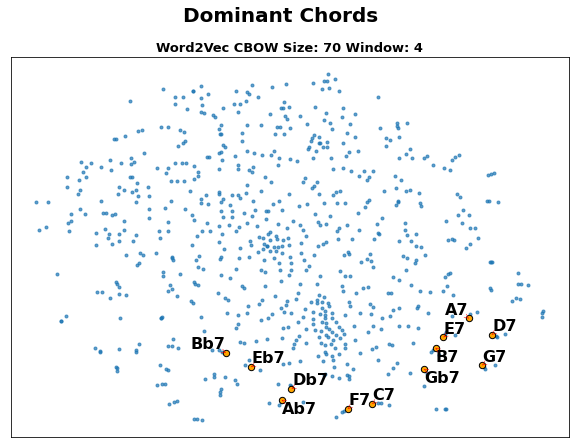

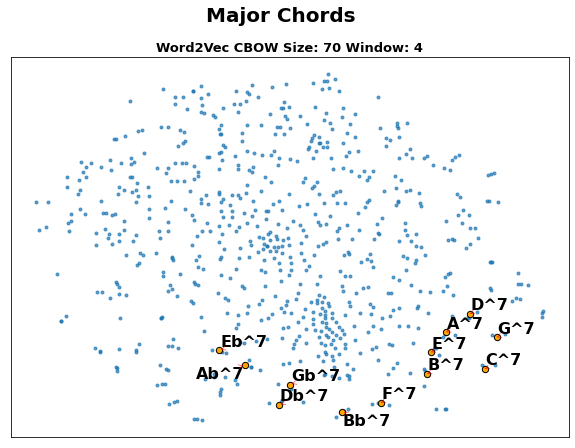

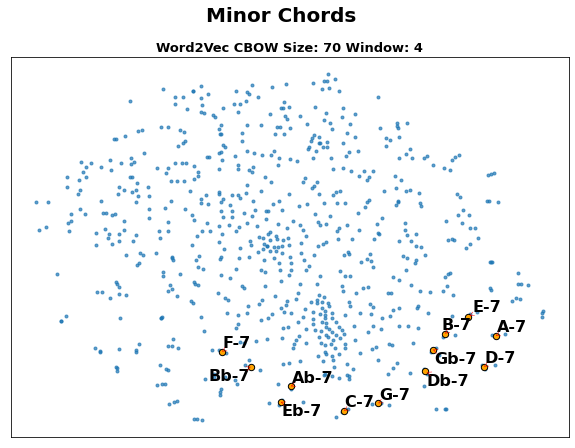

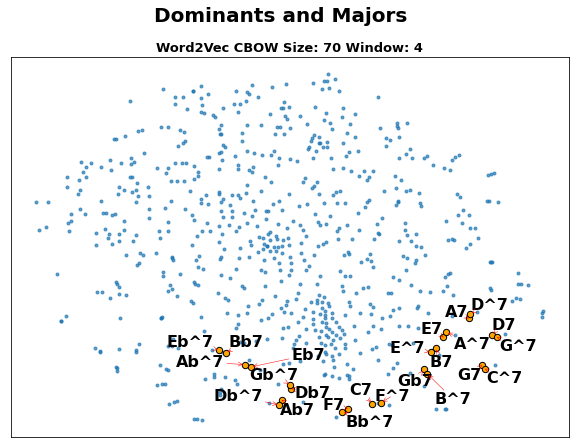

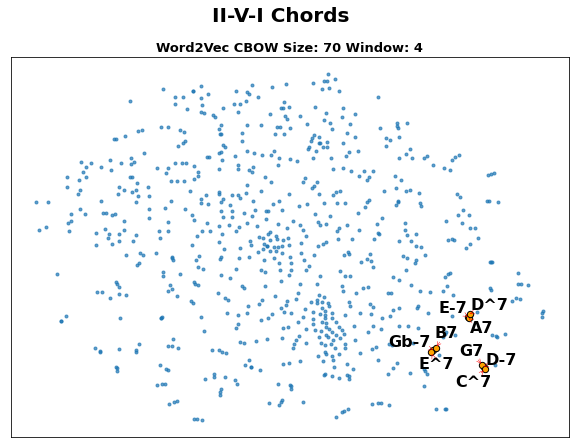

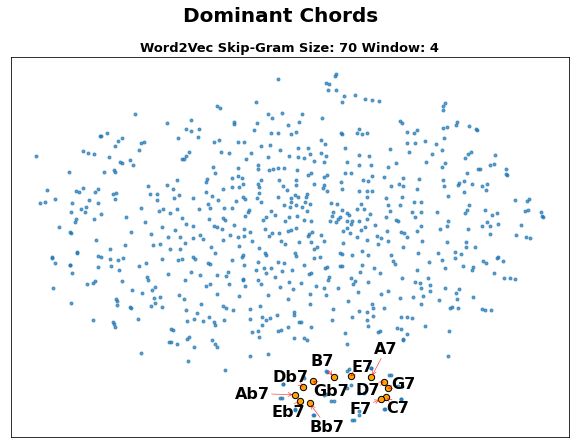

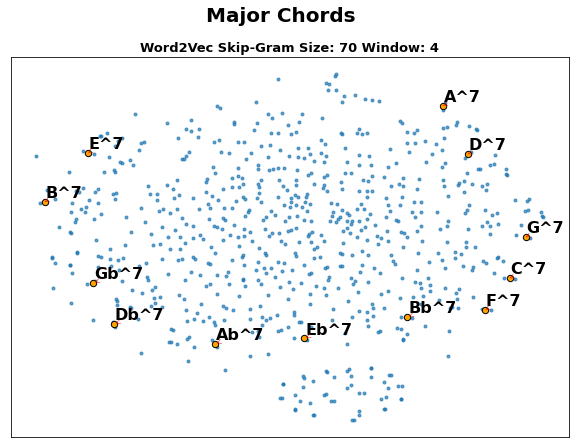

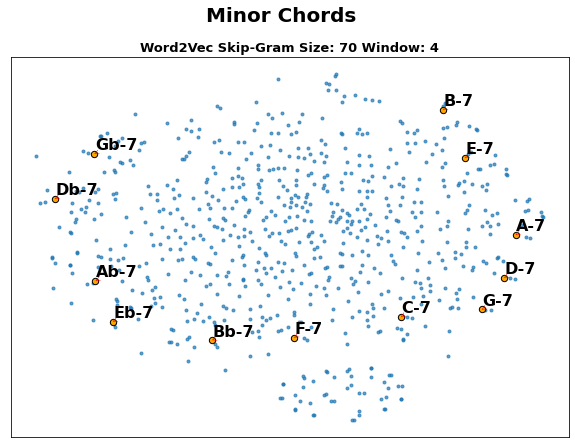

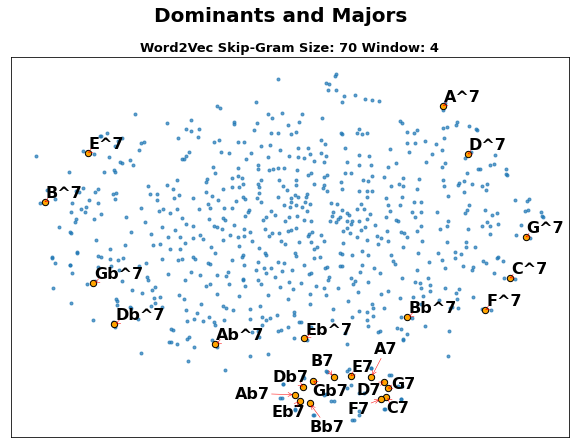

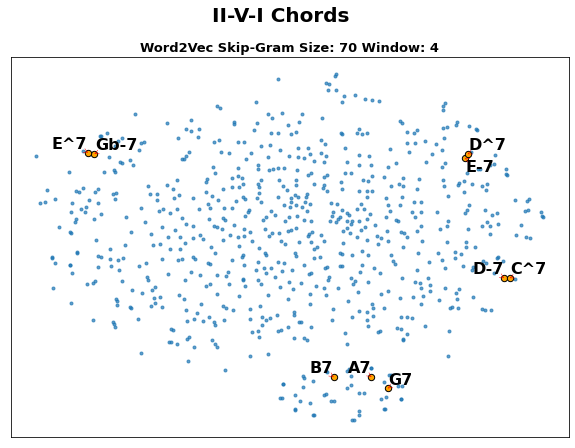

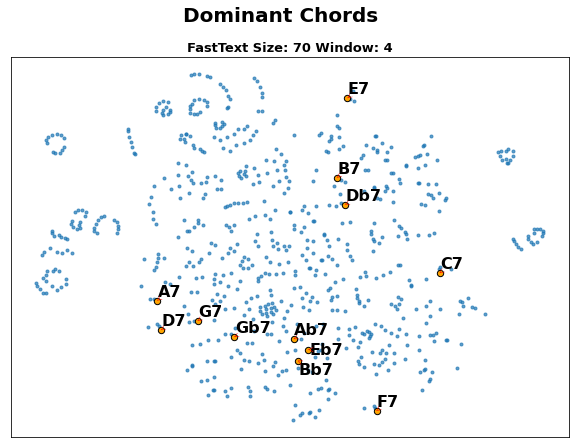

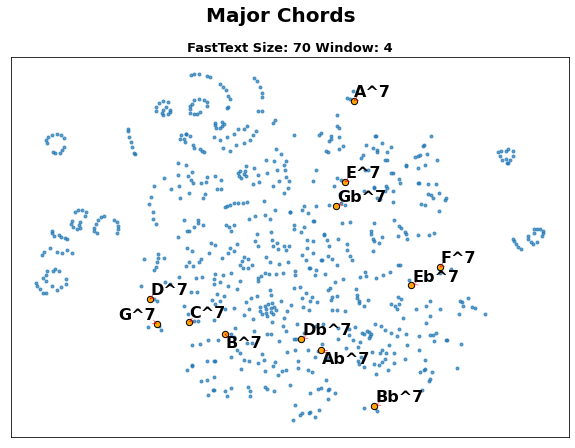

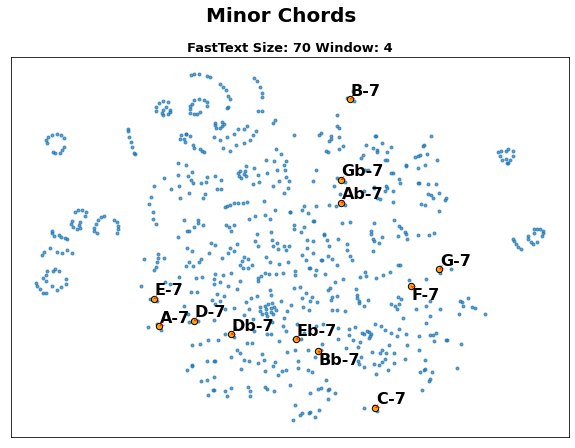

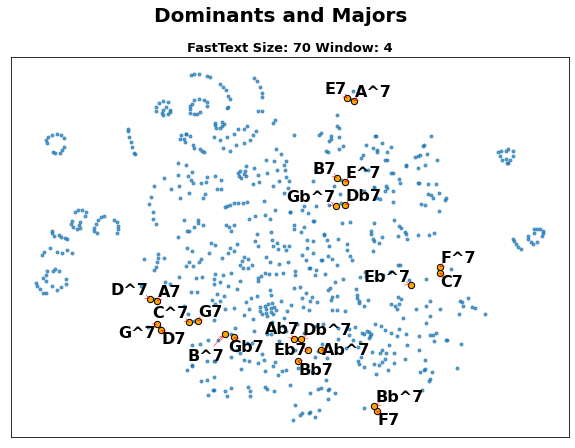

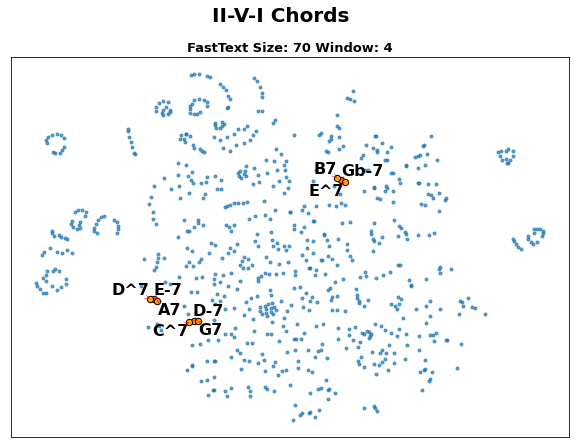

In [33]:
for m in models_list:
    plot_test_cases(m)

# GENERATE TSV FILES

In [148]:
VECTORS_PATH = "embeddings/vectors/"

In [146]:
for model in models_list:
    model_name = get_model_name(model, stripped=True)
    try:
        model.wv.save_word2vec_format(f"{VECTORS_PATH}{model_name}.{model_name}")
    except:
        print(f"Cannot save word2vec format in {model_name}")

Cannot save word2vec format in MultihotEmbeddingSize33


In [147]:
# python -m gensim.scripts.word2vec2tensor -i Word2VecSkipGramSize70.Word2VecSkipGramSize70 -o Word2VecSkipGramSize70

In [279]:
from os import listdir
from os.path import isfile, join
metadata_files = [f for f in listdir(VECTORS_PATH) if isfile(join(VECTORS_PATH, f)) and f.find('metadata')>0]

In [280]:
def get_extension(chord):
    return Chord(chord)._quality._quality

def get_root(chord):
    return Chord(chord)._root

def get_chord_class(chord):
    return qualities.CLASSIFICATION[get_extension(chord)]

def extend_metadata(df):
    df['Type'] = [get_extension(c) or "Maj" for c in df.Chord]
    df['Root'] = [get_root(c) for c in df.Chord]
    df['Class'] = [get_chord_class(c) for c in df.Chord]
    return df


for file in metadata_files:
    file_path = join(VECTORS_PATH, file)
    df = pd.read_csv(file_path, header=None, names=['Chord'])
    df = extend_metadata(df)
    df.to_csv(file_path,index=0, sep="\t")

# TSNE EXPLAINED

# https://distill.pub/2016/misread-tsne/

# PROJECTOR LINKS

- https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/SaxMan96/b04b97652ae888341feb300a0123d8cf/raw/c6a507268bfb3417c2d11d717e65239e7d2b7504/Word2VecSkipGramSize14_projector_config.json
- https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/SaxMan96/b82b2072cd200067f75bb54518b7a5a1/raw/474eb4f97bf8c67c74b951c3977ae3532c1e7d75/Word2VecCBOWSize13_projector_config.json
- https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/SaxMan96/c969c06ef0f255cc3613c5769152ab30/raw/dba7880791b569df7a304fbb82036671338b696d/FastTextSize13_projector_config.json
- https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/SaxMan96/b3ecca37320f23e448b51d2e377fc0b3/raw/2257d74e6de1c25d6ff9bb443c6e64b929cd6a27/Word2VecCBOWSize70_projector_config.json
- https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/SaxMan96/5262d6c44dca7db3df284c9657b2d6cc/raw/7a37a987d3cafc010a48ce3072067e4a025360bb/Word2VecSkipGramSize70_projector_config.json
- https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/SaxMan96/8587062e23a8a4edda38c0fc586a192d/raw/d948417b2a8fb790033709be4a1e607e57ca90b0/FastTextSize70_projector_config.json